# Training and evaluation notebook for InceptionV3 based Brevis Model.
<HR>
Models are trained on the CIFAR10 dataset, and uses CIFAR100 as an OOD dataset. <br>
    2 models are trained, one with branches using BrevisEnergy Loss and one using Cross entropy for all exits. <br>
    
    


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

### load datasets
Inception is initially trained using 224x224x3 image sizes, and because of its convolution process it can't accept CIFAR10 images at their default resolution, so we have scaled the images up to the default size for inception.
<hr>

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


## Initialize functions for building the loss functions 
<hr>

In [4]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


In [5]:
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl

def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)

def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost

In [6]:

class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = 0
        if epoch >= self.starting_epoch:
            val = tf.reduce_min([self.max_t, tf.cast((epoch - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)
        
class growth_update(lambda_update):
    ''' callback update method that checks the performance of the model against the validation set to decide if the annealing coef should be increased.
        provides greater control of the additional loss elements by updating their hyperparameters inteligently, rather then with only a preset schedule.
        
    '''
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.step = tf.Variable(initial_value = 0,dtype=tf.float32)
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        
        
        self.training = tf.Variable(initial_value=False, dtype=tf.bool)              
        self.past_val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        self.val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        
    def on_training_begin(self, logs={}):
        ''' indicate that training has begun, so val growth is an option.
        '''
        tf.print("training commenced, validation growth enabled")
        self.training.assign(True)
#     def on_training_end(self, logs={}):
#         ''' indicate that training has ended, so turn off val growth. Not sure if this is actually needed...
#         '''
#         tf.print("training commenced, validation growth enabled")
#         self.training.assign(False)
    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = self.lambda_t
        if epoch >= self.starting_epoch:
            if self.val_acc >= self.past_val_acc:
                
                val = tf.reduce_min([self.max_t, tf.cast((self.step - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
                tf.print("annealing coef updated to:", val)
                self.lambda_t.assign(val)
                self.past_val_acc.assign(self.val_acc)
                self.step.assign(self.step + 1)
            else:
                tf.print("val acc did not improve from {}, annealing coef not updated, remains at:{}".format(self.past_val_acc.numpy(), val.numpy()))
     # tf.print("past val acc =", self.past_val_acc)
        # self.past_val_acc.assign(self.val_acc)
        
    def on_test_end(self, logs=None):
        """ if training, save the performance results
        """
        self.val_acc.assign(logs.get('branch_exit_1_accuracy')+ logs.get('branch_exit_accuracy'))
        

## Build the Model
<hr>

In [6]:
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
     weights='imagenet',include_top=False)


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)


model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

# model.summary()
# train_ds, test_ds, validation_ds = prepareDataset(32)

EPOCHS = 1
for i in range(EPOCHS):
    history = model.fit(train_ds, epochs=EPOCHS, validation_data = validation_ds, batch_size=32)
    loss, accuracy = model.evaluate(test_ds, batch_size=32)
    model.save("inception_finetuned.hdf5")

313/313 [==============================] - 18s 57ms/step - loss: 0.2315 - accuracy: 0.9238


In [ ]:
# ### from scratch model

import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
# model.save('./models/cifaroutlier_EDL_adam.hdf5')
# loss = kl_loss(lambda_callback)
# loss = brevisEnergy(lambda_callback)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# _base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
#      weights='imagenet',include_top=False)

# x = _base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

# base_model = tf.keras.models.Model(inputs=_base_model.input, outputs=x)
# base_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#               loss=loss,
#               metrics=['accuracy'])
# history = base_model.fit(train_ds, validation_data=validation_ds, epochs=30,callbacks=[lambda_callback,earlyStop])


base_model = keras.models.load_model("./inception_finetuned.hdf5")
base_model.compile(
            # optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
            
              tf.keras.optimizers.Adam(),
              # tf.optimizers.SGD(lr=0.001, momentum=0.9)
              loss=loss,
              metrics=['accuracy'])

base_model.fit(train_ds, validation_data = validation_ds, epochs=3)
# from keras_flops import get_flops    
# flops = get_flops(base_model, batch_size=1)
# print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

Epoch 1/3
 423/1407 [========>.....................] - ETA: 3:20 - loss: 1.0879 - accuracy: 0.6529

## Branch the model
First we will train the BrevisNet version of the model with BrevisEnergy loss
<hr>

In [7]:
def _branch_flat(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(1024, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch1024"))(branchLayer)
    branchLayer = layers.Dense(512, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch512"))(branchLayer)
    # output = branch.CrossEntropyEndpoint(targets.shape[-1], name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output


def _branch_conv1_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

In [9]:
from tensorflow.python.platform import tf_logging as logging
class BrevisEarlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


In [25]:
tf.keras.backend.clear_session()

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # tf.print((A + B),summarize=-1)
        # tf.print((info_reg + D),summarize=-1)
        
        # tf.print(((A + B) + info_reg + D).shape)
        return (A + B) + info_reg +  D # info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        # tf.print(C)
        return tf.reduce_mean(info_reg+ D )
    return auxloss     


growth_callback = growth_update(100,0.,max_t = 1, starting_epoch =0)
earlyStop = _earlyStopping(monitor=["val_classification_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=5,restore_best_weights=True)
auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

model = brevis.BranchModel(name="./inception_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv2,_branch_conv2],
                          ["mixed0","mixed1",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)

model.setTrainable(True)
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])


# model.setTrainable(True)
# model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
#                   optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   # optimizer = tf.optimizers.RMSprop(0.045),
#                   # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#               metrics=['accuracy'])
# model.evaluate(test_ds)




Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  mixed0
add Branch to branch point  mixed1
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000024810688B48>
Freezing Main Layers and setting branch layers training to true


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [26]:
model.fit(train_ds, epochs = 60, validation_data=validation_ds, transfer=True,callbacks=[growth_callback, earlyStop])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/60
1407/1407 [==============================] - 184s 121ms/step - loss: 1.1416 - classification_loss: 0.1178 - branch_exit_loss: 0.5217 - branch_exit_1_loss: 0.5021 - classification_accuracy: 0.9639 - branch_exit_accuracy: 0.6041 - branch_exit_1_accuracy: 0.6192 - val_loss: 1.0467 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.4795 - val_branch_exit_1_loss: 0.3990 - val_classification_accuracy: 0.9442 - val_branch_exit_accuracy: 0.6486 - val_branch_exit_1_accuracy: 0.7122
annealing coef updated to: 0.01
Epoch 2/60
1407/1407 [==============================] - 174s 120ms/step - loss: 0.9303 - classification_loss: 0.1178 - branch_exit_loss: 0.4177 - branch_exit_1_loss: 0.3947 - classification_accuracy: 0.9639 - branch_exit_accuracy: 0.7440 - branch_exit_1_accuracy: 0.7595 - val_loss: 0.9571 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.4132 - val_branch_exit_1_lo

In [11]:
model.fit(train_ds, epochs = 60, validation_data=validation_ds, transfer=False,callbacks=[growth_callback, earlyStop])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/60
1407/1407 [==============================] - 339s 228ms/step - loss: 4.3591 - classification_loss: 1.1437 - branch_exit_loss: 1.5966 - branch_exit_1_loss: 1.6187 - classification_accuracy: 0.6057 - branch_exit_accuracy: 0.5141 - branch_exit_1_accuracy: 0.5225 - val_loss: 2.7387 - val_classification_loss: 0.7501 - val_branch_exit_loss: 0.9975 - val_branch_exit_1_loss: 0.9911 - val_classification_accuracy: 0.7494 - val_branch_exit_accuracy: 0.6522 - val_branch_exit_1_accuracy: 0.6482
annealing coef updated to: 0.01
Epoch 2/60
1407/1407 [==============================] - 319s 225ms/step - loss: 2.5443 - classification_loss: 0.6857 - branch_exit_loss: 0.9416 - branch_exit_1_loss: 0.9171 - classification_accuracy: 0.7707 - branch_exit_accuracy: 0.6702 - branch_exit_1_accuracy: 0.6789 - val_loss: 2.3817 - val_classification_loss: 0.6844 - val_branch_exit_loss: 0.8403 - val_branch_exit_1_loss: 0.85

In [27]:
model.save("./models/journal_models/inception_EDL_ES_.hdf5")

In [60]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

growth_callback = growth_update(50,0.,max_t = 0.1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)


# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./inception_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv2,_branch_conv2],
                          ["mixed0","mixed1",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.setTrainable(True)
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer = tf.optimizers.RMSprop(0.045),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
              preset="", metrics=['accuracy'])

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  mixed0
add Branch to branch point  mixed1
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000015D1D6B2E48>
Freezing Main Layers and setting branch layers training to true

preset: Other


In [61]:
model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/10
1407/1407 [==============================] - 231s 153ms/step - loss: 1.1369 - classification_loss: 0.1178 - branch_exit_loss: 0.5099 - branch_exit_1_loss: 0.5091 - classification_accuracy: 0.9638 - branch_exit_accuracy: 0.6125 - branch_exit_1_accuracy: 0.6108 - val_loss: 1.0231 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.4162 - val_branch_exit_1_loss: 0.4388 - val_classification_accuracy: 0.9442 - val_branch_exit_accuracy: 0.7016 - val_branch_exit_1_accuracy: 0.6878
annealing coef updated to: 0.02
Epoch 2/10
1407/1407 [==============================] - 200s 138ms/step - loss: 1.0239 - classification_loss: 0.1178 - branch_exit_loss: 0.4473 - branch_exit_1_loss: 0.4587 - classification_accuracy: 0.9638 - branch_exit_accuracy: 0.7361 - branch_exit_1_accuracy: 0.7220 - val_loss: 1.0470 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.4295 - val_branch_exit_1_lo

In [62]:
model.save("./models/journal_models/inception_Brevis_10_frozen.hdf5")

In [9]:

growth_callback = growth_update(10,1.,max_t = 1., starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)


# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)


# model = brevis.BranchModel(name="./inception_finetuned.hdf5", custom_objects={})
model = tf.keras.models.load_model("./models/journal_models/inception_CE_15_adam.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"custom_loss_function":loss_wrapper(growth_callback)})
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.setTrainable(True)
model.compile(loss=[trunk_loss,trunk_loss,trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.05, momentum=0.9),
                  # optimizer = tf.optimizers.RMSprop(0.045),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
             metrics=['accuracy'])
# model.evaluate(test_ds)

Freezing Main Layers and setting branch layers training to true


In [20]:
model.fit(train_ds, epochs = 6, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0.1
Epoch 1/6
1407/1407 [==============================] - 140s 92ms/step - loss: 1.2460 - classification_loss: 0.1178 - branch_exit_loss: 0.6271 - branch_exit_1_loss: 0.5011 - classification_accuracy: 0.9638 - branch_exit_accuracy: 0.6972 - branch_exit_1_accuracy: 0.7469 - val_loss: 1.2377 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.5433 - val_branch_exit_1_loss: 0.5261 - val_classification_accuracy: 0.9442 - val_branch_exit_accuracy: 0.7282 - val_branch_exit_1_accuracy: 0.7404
annealing coef updated to: 0.2
Epoch 2/6
1407/1407 [==============================] - 132s 92ms/step - loss: 1.1089 - classification_loss: 0.1178 - branch_exit_loss: 0.5165 - branch_exit_1_loss: 0.4746 - classification_accuracy: 0.9638 - branch_exit_accuracy: 0.7704 - branch_exit_1_accuracy: 0.7909 - val_loss: 1.5176 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.6510 - val_branch_exit_1_loss:

In [24]:
growth_callback = growth_update(10,3.,max_t = .3, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)

model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer = tf.optimizers.RMSprop(0.045),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
              preset="", metrics=['accuracy'])


preset: Other


In [25]:
model.fit(train_ds, epochs = 6, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0.3
Epoch 1/6
1407/1407 [==============================] - 147s 98ms/step - loss: 0.8075 - classification_loss: 0.1178 - branch_exit_loss: 0.3659 - branch_exit_1_loss: 0.3238 - classification_accuracy: 0.9638 - branch_exit_accuracy: 0.8489 - branch_exit_1_accuracy: 0.8731 - val_loss: 1.0398 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.4393 - val_branch_exit_1_loss: 0.4323 - val_classification_accuracy: 0.9442 - val_branch_exit_accuracy: 0.8252 - val_branch_exit_1_accuracy: 0.8306
annealing coef updated to: 0.3
Epoch 2/6
1407/1407 [==============================] - 136s 95ms/step - loss: 0.6640 - classification_loss: 0.1178 - branch_exit_loss: 0.2906 - branch_exit_1_loss: 0.2556 - classification_accuracy: 0.9638 - branch_exit_accuracy: 0.8791 - branch_exit_1_accuracy: 0.8958 - val_loss: 1.0227 - val_classification_loss: 0.1682 - val_branch_exit_loss: 0.4425 - val_branch_exit_1_loss:

In [26]:
model.evaluate(test_ds)

313/313 [==============================] - 19s 59ms/step - loss: 1.1192 - classification_loss: 0.1892 - branch_exit_loss: 0.4793 - branch_exit_1_loss: 0.4507 - classification_accuracy: 0.9394 - branch_exit_accuracy: 0.8328 - branch_exit_1_accuracy: 0.8505


[1.1191997528076172,
 0.1891820728778839,
 0.4793119728565216,
 0.45070552825927734,
 0.9394000172615051,
 0.8327999711036682,
 0.8504999876022339]

In [41]:
model.save("./models/journal_models/inception_brevis_final.hdf5")

In [47]:
def _branch_flat(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(1024, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch1024"))(branchLayer)
    branchLayer = layers.Dense(512, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch512"))(branchLayer)
    # output = branch.CrossEntropyEndpoint(targets.shape[-1], name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

In [48]:

growth_callback = growth_update(50,0.,max_t = 0.1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)


# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)



model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv2,_branch_conv2],
                          ["conv2_block1_out","conv2_block3_out",
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.setTrainable(True)

model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy',auxlossMetric])



Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_4')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_5')>]
branch added <brevis.core_v2.BranchModel object at 0x00000156AB073C48>
Freezing Main Layers and setting branch layers training to true

preset: Other


In [17]:
model.save("./models/journal_models/Inception_EDL_IAR_e15.hdf5")

In [52]:
model = brevis.BranchModel(name="./models/inception_finetuned.hdf5", custom_objects={})
# flops = get_flops(model, batch_size=1)
# print(f"FLOPS: {flops / 10 ** 9:.03} G")
model.compile(loss=[trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer="adam",
              preset="", metrics=['accuracy'])
model.evaluate(test_ds)


preset: Other
313/313 [==============================] - 18s 52ms/step - loss: 0.1502 - accuracy: 0.9585


[0.15015941858291626, 0.9585000276565552]

## Get the flop cost for each branch output

In [35]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 1.89 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 2.35 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 5.92 G


In [20]:
lambda_callback = lambda_update(100,0,max_t = 0.01)
model = tf.keras.models.load_model("./models/journal_models/inception_CE_15_adam.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"custom_loss_function":loss_wrapper(lambda_callback)})

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [13]:
output_ID= evaluate.getPredictions_Energy(model, test_ds,  values =['entropy'], stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3
['entropy']


In [14]:
output_OOD = evaluate.getPredictions_Energy(model, test_ds100,  values =['entropy'], stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3
['entropy']


In [17]:
# output_OOD_svhn = getPredictions_Energy(model, test_ds_svhn,stopping_point=313)
# output_OOD_svhn['correct']=0
# output_OOD_svhn['outlier']=1


In [17]:
def EvaluateOOD(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        rollOver_OOD_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _OOD = OOD.copy()
        _ID.append(_ID.pop(0))
        _OOD.append(_OOD.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Input_OOD=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Accepted_OOD_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            _OOD = [_OOD[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)

            if len(rollOver_ID_indices)>0:
                # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                output_ID = output_ID.iloc[rollOver_ID_indices]
            if len(rollOver_OOD_indices)>0:
                # if plot:
                # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                output_OOD = output_OOD.iloc[rollOver_OOD_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions", "OOD Inputs"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

            if plot:
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    print(ymax, ywidth)
                    print(xmax, _threshold- xmax[1]/10 )
                    
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                OOD_accepted = output_OOD
                OOD_rejected = None
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                else: ### metrics that require greater than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                rollOver_ID_indices = ID_rejected.index
                rollOver_OOD_indices = OOD_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Input_OOD.append(len(output_OOD))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_OOD_list.append(len(OOD_accepted))
            Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            Accepted_Accuracy_list.append(overall_accepted_acc)
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "OOD_Inputs":Input_OOD,
        "Test_Accuracy":Test_accuracy,
        # "RollOver_Accuracy":Rollover_accuracy,
        "Threshold":Thresholds,
        "Accepted ID":Accepted_ID_list,
        "Accepted OOD":Accepted_OOD_list,
            
        "Accepted_Correct":Acceptance_correct,
        "Accepted_ID_Ratio":Accepted_Ratio_list,
        "Acceptance_Accuracy":Accepted_Accuracy_list,

        # "Flops":Branch_flops,
        # "Cost Ratio":,                                  
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

### T/F in distribution performance
<hr>

In [21]:
# CE early stopping
EvaluateOOD(output_ID, output_OOD, ["entropy"], "gmean",plot=False)

metric:  entropy threshold:  gmean
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8246  0.014288         6246          1870              6033           0.769591             0.743346
1     exit_2       3754        8130         0.8448   0.04645         1360          1295              1194           0.512241             0.449718
2  Main_exit       2394        6835         0.8996        NA         2394          6835              1740           0.259400             0.188536


In [19]:
# EDL frozen, 15epochs no kl or info_reg
EvaluateOOD(output_ID, output_OOD, ["entropy"], "gmean",plot=True)

metric:  energy threshold:  gmean


KeyError: 'energy'

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.15123779708403612 Best Threshold=-81.88243865966797, G-Mean=0.773923409926957, TPR=0.8205285802089736, FPR=0.2700346351367491


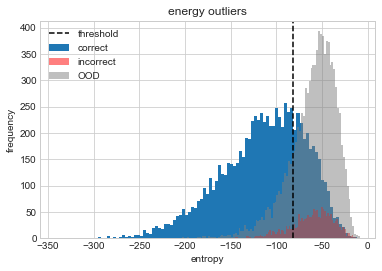

['exit_1']
m energy
metric energy
energy  lr_auc 0.14366578647296668 Best Threshold=-79.849853515625, G-Mean=0.7847462473127419, TPR=0.8188539741219963, FPR=0.24794079025904261


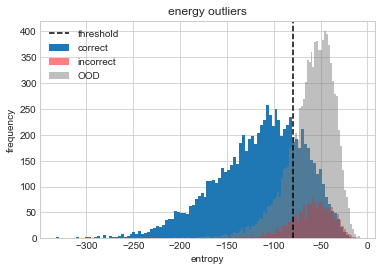

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.07529892333495643 Best Threshold=-2.4509100914001465, G-Mean=0.8572885706881755, TPR=0.8729372937293729, FPR=0.15807962529274006


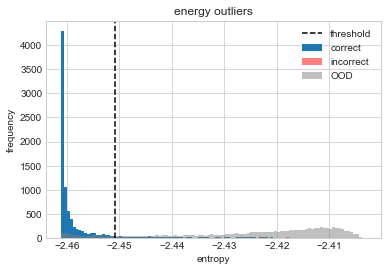

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8373 -81.882439         6405          1782              6112           0.782338             0.746549
1     exit_2       3595        8218         0.8377 -79.849854         1141          1033               995           0.524839             0.457682
2  Main_exit       2454        7185         0.9394         NA         2454          7185              2088           0.254591             0.216620


In [18]:
# EDL frozen, 15epochs no kl or info_reg
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.12849606083586113 Best Threshold=3.2198143005371094, G-Mean=0.7958496889074013, TPR=0.8523255813953489, FPR=0.2568840579710145


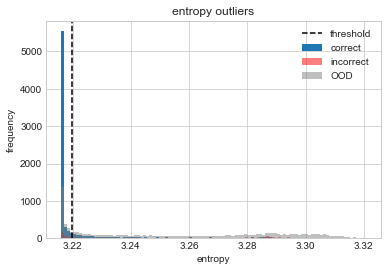

['exit_1']
m entropy
metric entropy
entropy  lr_auc 0.12466646047371904 Best Threshold=3.2200355529785156, G-Mean=0.8054832866006317, TPR=0.8408812729498164, FPR=0.22842457566339947


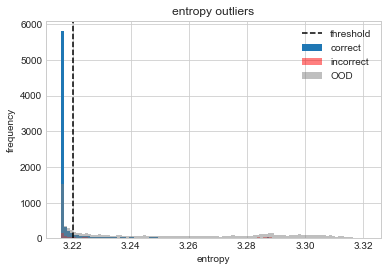

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.13248245670676545 Best Threshold=3.2185394763946533, G-Mean=0.7972006669250856, TPR=0.8439269981120201, FPR=0.2469385328736179


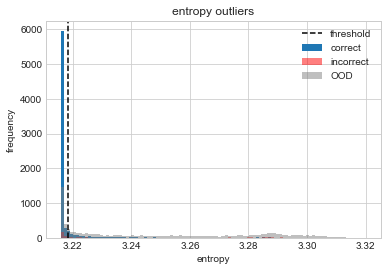

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8280  3.219814         6408          2139              6153           0.749737             0.719902
1     exit_2       3592        7861         0.8366  3.220036         1143          1319               997           0.464257             0.404955
2  Main_exit       2449        6542         0.8411        NA         2449          6542              1567           0.272383             0.174285


In [22]:
# CE not frozen, 15epochs
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)

### ID/OOD branch performance
<hr>

metric:  energy threshold:  gmean
energy  lr_auc 0.12200723534832629 Best Threshold=-70.56578826904297, G-Mean=0.8083515421874572, TPR=0.8510765550239234, FPR=0.23222862632084534


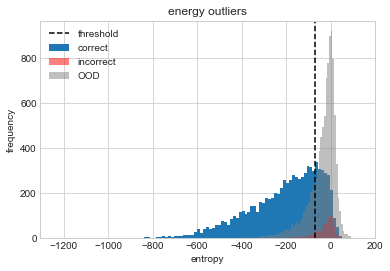

['exit_1', 'exit_2']
energy  lr_auc 0.12585868238042153 Best Threshold=-79.33734130859375, G-Mean=0.8056013219699143, TPR=0.8240802675585285, FPR=0.21246325690770135


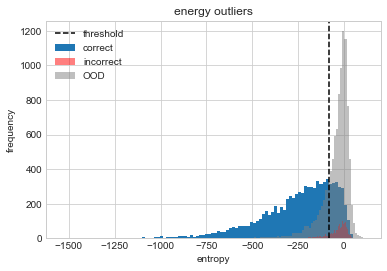

['exit_1', 'exit_2']
energy  lr_auc 0.07529751804220233 Best Threshold=-2.45090913772583, G-Mean=0.8573427660019882, TPR=0.8729372937293729, FPR=0.15797317436661698


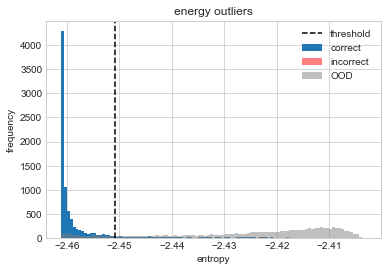

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8328 -70.565788         6644          2070              6394           0.762451             0.733762
1     exit_2       3356        7930         0.8505 -79.337341         1061          1059               920           0.500472             0.433962
2  Main_exit       2295        6871         0.9394         NA         2295          6871              1921           0.250382             0.209579


In [29]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.16797340378359926 Best Threshold=-31.158634185791016, G-Mean=0.7677011723681414, TPR=0.8454968944099379, FPR=0.3029364224137931


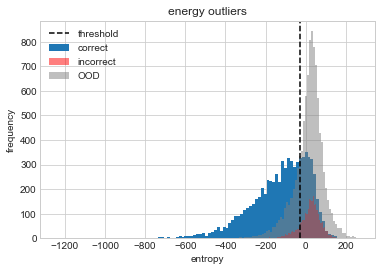

['exit_1', 'exit_2']
energy  lr_auc 0.1640018737186706 Best Threshold=-39.64511489868164, G-Mean=0.7648927562520043, TPR=0.7669270833333334, FPR=0.23713617463617465


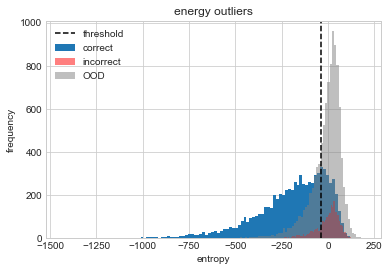

['exit_1', 'exit_2']
energy  lr_auc 0.07529751804220233 Best Threshold=-2.45090913772583, G-Mean=0.8573427660019882, TPR=0.8729372937293729, FPR=0.15797317436661698


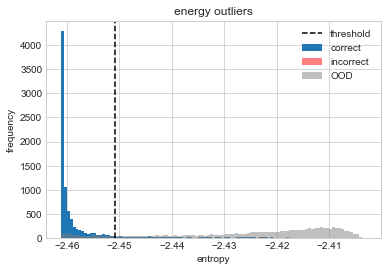

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7424 -31.158634         5574          2053              5175           0.730825             0.678511
1     exit_2       4426        7947         0.7696 -39.645115         1795          1742              1445           0.507492             0.408538
2  Main_exit       2631        6205         0.9394         NA         2631          6205              2289           0.297759             0.259054


In [23]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)
# evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "gmean",plot=True)



In [55]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",plot=False)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",plot=False)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.14161445588079627 Best Threshold=0.3423153758049011, G-Mean=0.7816157424761103, TPR=0.7985074626865671, FPR=0.23491864831038797
['exit_1', 'exit_2']
entropy  lr_auc 0.137654082629813 Best Threshold=0.28195253014564514, G-Mean=0.7901470688963526, TPR=0.8278520041109969, FPR=0.24584057611124907
['exit_1', 'exit_2']
entropy  lr_auc 0.0751540025196899 Best Threshold=3.2358973026275635, G-Mean=0.8573427660019882, TPR=0.8729372937293729, FPR=0.15797317436661698
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7990  0.342315         6519          2561              6113           0.717952             0.673238
1     exit_2       3481        7439         0.8054  0.281953         1235          1549              1044           0.443606             0.375000
2  Main_exit       2246        5890         0.939

## Entropy Branch version
Now we build a branched model with the entropy metric and cross entropy loss for comparision.
<hr>

In [23]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./models/inception_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv2,_branch_conv2],
                          ["mixed0","mixed1",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])




Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  mixed0
add Branch to branch point  mixed1
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000001DC76EB0848>

preset: Other


In [24]:
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=True,callbacks=[lambda_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/5
1407/1407 [==============================] - 356s 245ms/step - loss: 2.1845 - classification_loss: 0.0415 - branch_exit_loss: 1.0931 - branch_exit_1_loss: 1.0498 - classification_accuracy: 0.9855 - branch_exit_accuracy: 0.6214 - branch_exit_1_accuracy: 0.6342 - val_loss: 1.5822 - val_classification_loss: 0.0222 - val_branch_exit_loss: 0.7844 - val_branch_exit_1_loss: 0.7756 - val_classification_accuracy: 0.9926 - val_branch_exit_accuracy: 0.7164 - val_branch_exit_1_accuracy: 0.7246
annealing coef updated to: 0.001
Epoch 2/5
1407/1407 [==============================] - 329s 232ms/step - loss: 1.3876 - classification_loss: 0.0258 - branch_exit_loss: 0.7093 - branch_exit_1_loss: 0.6525 - classification_accuracy: 0.9915 - branch_exit_accuracy: 0.7524 - branch_exit_1_accuracy: 0.7702 - val_loss: 1.3860 - val_classification_loss: 0.0156 - val_branch_exit_loss: 0.6570 - val_branch_exit_1_los

In [25]:
model.evaluate(test_ds)

313/313 [==============================] - 18s 57ms/step - loss: 1.3121 - classification_loss: 0.1717 - branch_exit_loss: 0.5767 - branch_exit_1_loss: 0.5637 - classification_accuracy: 0.9608 - branch_exit_accuracy: 0.8066 - branch_exit_1_accuracy: 0.8175


[1.3121238946914673,
 0.1716654747724533,
 0.5767245292663574,
 0.5637335181236267,
 0.9607999920845032,
 0.8065999746322632,
 0.8174999952316284]

In [26]:
model.save("./models/journal_models/inception_B_conv3_5.hdf5")

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
# metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
# metrics =['energy','uncert','expected_entropy','calibration']

metrics = ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
def calc_auc_OOD(ID,OOD,metrics=['energy'],OOD_rate=[.1,.2,.5,1], plot=False):
    points = []
    # OOD_rate = [0,.1,.2,.5,1]
    _output_ID = ID
    _output_OOD = OOD

    _output_ID["outlier"]=0
    _output_OOD["outlier"]=1
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    for i in OOD_rate:
        # print(int(min((len(_output_ID) * i),len(_output_ID))))
        _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
        print("OOD size",len(_OOD))
        _df = pd.concat([_output_ID,_OOD], ignore_index=True)
        y_true = np.int32(_df['outlier'])

    #     print(len(_df))
    #     for metric in metrics:
    #         points.append([])
    #         # print(metric, ":", average_precision_score(y_true, _df[metric]))

    #         Correct = _df.loc[(_df['correct'] == True)]
    #         Incorrect = _df.loc[(_df['correct'] == False)]
    #         fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
    #         gmeans = sqrt(tpr * (1-fpr))
    #         ix = argmax(gmeans)
    #         _threshold = thresholds[ix]
    #         # _threshold = np.array(Correct[metric]).mean()
        plots = []
        for metric in metrics:    
            lr_auc = roc_auc_score(y_true, _df[metric])
            print("lr_auc",lr_auc)
            if metric in lessThanMetrics:
                pos_label = 0
            else:
                pos_label = 1
            fpr, tpr, thresholds = roc_curve(y_true, _df[metric],pos_label=pos_label)
            gmeans = sqrt(tpr * (1-fpr))
            # print(gmeans)
            # locate the index of the largest g-mean
            ix = argmax(gmeans)
            threshold = thresholds[ix]
            print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
            _thresholds.append(threshold)
            # plot the roc curve for the model
            plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
        # if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

# calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       

calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])      

In [12]:
def calc_auc_OOD(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True, OOD_rate=[.1,.2,.5,1], plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for rate in OOD_rate:
                # print(int(min((len(_output_ID) * i),len(_output_ID))))
                print("OOD size",rate)
                _OOD_frac=[]
                Exit_Name=[]
                rollOver_ID_indices = pd.Index([])
                rollOver_OOD_indices = pd.Index([])
                Input_ID=[]
                Input_OOD=[]
                Accepted_list =[]
                Accepted_ID_list = []
                Accepted_OOD_list = []
                Acceptance_correct =[]
                Input_predictions =[]
                Accepted_Ratio_list=[]
                Accepted_Accuracy_list=[]
                # Branch_cost =[17443270,29419724,132134023] #flat exit costs
                # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

                # Base_cost = 112698838
                Branch_flops = []
                Thresholds=[]
                Test_accuracy =[]
                Rollover_accuracy=[]
                Results=[]
                for i, output in enumerate(_OOD):
                    
                    amount = min(len(_ID[i]) * rate,len(_ID[i]))
                    # print("len",amount)
                    _OOD_frac.append(_OOD[i].iloc[0:int(amount)])
                    # print(len(_OOD_frac[i]),len(_ID[i]))
                # _df = pd.concat([_ID,_OOD], ignore_index=True)
                # y_true = np.int32(_df['outlier'])
                for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD_frac)): 
                    Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))

                    legend = ["threshold","correct","incorrect", "OOD"]
                    Correct = output_ID.loc[(output_ID['correct'] == True)]
                    Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                    if plot:
                        _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                        _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                        _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram


                    if threshold:
                        if type(threshold) is list:
                            if j >= len(threshold): #no threshold in the array so treat as None.
                                continue
                            _threshold = threshold[j]
                        else:
                            _threshold = threshold
                        if _threshold == "mean":
                            # _threshold = np.array(ID[metric]).mean()
                            Correct = output_ID.loc[(output_ID["correct"] == True)]
                            _threshold = np.array(Correct[metric]).mean()
                        if _threshold == "gmean":
                            AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metrics,plot = False)
                            _threshold = AUC_thresholds[j]
                        if _threshold == "PR_AUC":
                            precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                            _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                        else:
                            _threshold = np.float32(_threshold)

                    if len(rollOver_ID_indices)>0:
                        # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                    if len(rollOver_OOD_indices)>0:
                        # if plot:
                        # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]

                    if plot:
                        plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                        plt.title(metric + " outliers")
                        plt.legend(legend)
                        plt.xlabel("entropy")
                        plt.ylabel("frequency")
                        plt.show()
                    if main_exit_included and i == len(_ID)-1 :
                        Exit_Name.append("Main_exit")
                        _threshold
                        if plot:
                            print("main_exit")
                        OOD_accepted = output_OOD
                        OOD_rejected = None
                        ID_accepted = output_ID
                        ID_rejected = None
                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = None
                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = None
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        _threshold = "NA"
                        ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                        # if metric in lessThanMetrics:
                            # _threshold = math.inf
                        # else:
                            # _threshold = -math.inf
                    # print(_threshold)
                    else:
                        if metric in lessThanMetrics: ## metrics that require less than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                        else: ### metrics that require greater than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                        rollOver_ID_indices = ID_rejected.index
                        rollOver_OOD_indices = OOD_rejected.index
                        if i >= len(exit_labels):
                            exit_labels.append("exit_{}".format(i+1))
                        print(exit_labels)
                        Exit_Name.append(exit_labels[i])
                    Thresholds.append(_threshold)

                    Results.append(accepted_correct +accepted_incorrect)
                    Input_ID.append(len(output_ID))
                    Input_OOD.append(len(output_OOD))
                    Accepted_ID_list.append(len(ID_accepted))
                    Accepted_OOD_list.append(len(OOD_accepted))
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                    Acceptance_correct.append(len(accepted_correct))
                    Accepted_Accuracy_list.append(overall_accepted_acc)
                df = pd.DataFrame({
                "Exit_Name":Exit_Name,
                "ID_Inputs":Input_ID,
                "OOD_Inputs":Input_OOD,
                "Test_Accuracy":Test_accuracy,
                # "RollOver_Accuracy":Rollover_accuracy,
                "Threshold":Thresholds,
                "Accepted ID":Accepted_ID_list,
                "Accepted OOD":Accepted_OOD_list,

                "Accepted_Correct":Acceptance_correct,
                "Accepted_ID_Ratio":Accepted_Ratio_list,
                "Acceptance_Accuracy":Accepted_Accuracy_list,

                # "Flops":Branch_flops,
                # "Cost Ratio":,                                  
                              })
                with pd.option_context('expand_frame_repr', False):
                    print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))


In [23]:
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  entropy threshold:  gmean
OOD size 0.1
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.8280  3.219811         6408           217              6153           0.967245             0.928755
1     exit_2       3592         783         0.8366  3.220037         1143           147               997           0.886047             0.772868
2  Main_exit       2449         636         0.8411        NA         2449           636              1567           0.793841             0.507942
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.8280  3.219811         6408           420              6153           0.938489 

In [19]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  energy threshold:  gmean
OOD size 0.1
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.8299 -84.521584         6404           200              6071           0.969715             0.919291
1     exit_2       3596         800         0.8335  -84.60231         1088           108               938           0.909699             0.784281
2  Main_exit       2508         692         0.9394         NA         2508           692              2150           0.783750             0.671875
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.8299 -84.521584         6404           383              6071           0.94

In [17]:
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)

# 268,519,1273,2539

metric:  entropy threshold:  gmean
OOD size 0.1
entropy  lr_auc 0.12849606083586113 Best Threshold=3.2198143005371094, G-Mean=0.7958496889074013, TPR=0.8523255813953489, FPR=0.2568840579710145
['exit_1']
entropy  lr_auc 0.12466646047371904 Best Threshold=3.2200355529785156, G-Mean=0.8054832866006317, TPR=0.8408812729498164, FPR=0.22842457566339947
['exit_1', 'exit_2']
entropy  lr_auc 0.13248245670676545 Best Threshold=3.2185394763946533, G-Mean=0.7972006669250856, TPR=0.8439269981120201, FPR=0.2469385328736179
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.8280  3.219814         6408           217              6153           0.967245             0.928755
1     exit_2       3592         783         0.8366  3.220036         1143           147               997           0.886047             0.772868
2  Main_exit       2449         636         0.

In [ ]:
# 95, 181, 417, 798